In [1]:
import requests
import re
from bs4 import BeautifulSoup
import pandas as pd
import seaborn as sns
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
base_url = "https://www.imdb.com/search/title/?title_type=tv_series&num_votes=1000,&languages=en&sort=user_rating,desc&start=0"


In [2]:
shows = []
shows_per_page = 50
for page_number in range(0, 1000, shows_per_page):
    url = base_url + str(page_number) 
    response = requests.get(url)
    soup = BeautifulSoup(response.text, "html.parser")
    for show_div in soup.find_all("div", class_="lister-item-content"):
        show = {}
        rank = show_div.find("span", class_="lister-item-index unbold text-primary").text.strip().replace('.','')
        show["Rank"] = int(rank)
        show["Title"] = show_div.find("h3").a.text.strip()
        show["Year"] = show_div.find("span", class_="lister-item-year").text.strip().replace('(','').replace(')','').replace('II','').replace('I','')
        year = show["Year"].strip()
        if "–" in year:
            start_year, end_year = year.split("–")
            show["Start Year"] = start_year
            show["End Year"] = end_year
        else:
            show["Start Year"] = year
            show["End Year"] = year
        show["Rating"] = show_div.find("strong").text.strip()
        # show["Duration"] = show_div.find("span", class_="runtime").text.strip().replace('min','') if show_div.find("span", class_="runtime") else None
        value = show_div.find_all("span", attrs={"name": "nv"})
        show["Votes"] = value[0].text.replace(',','') 
        genre = show_div.find("span", class_="genre").text.strip()
        genres = [g.strip() for g in genre.split(",")]
        show["Genre"] = ", ".join(genres)
        show["Genre"] = show["Genre"].strip('"')
#         show["Certificate"] = show_div.find("span", class_="certificate")
#         show["Certificate"] = show["Certificate"].replace('[', '').replace(']', '')
        certificate_elem = show_div.find("span", class_="certificate")
        if certificate_elem is not None:
            certificate = certificate_elem.text.strip().replace('[', '').replace(']', '')
        else:
            certificate = "Not Found"
        show["Certificate"] = certificate 
         # Extract the primary genre from the "genre" field
        genre = show_div.find("span", class_="genre").text.strip()
        genres = [g.strip() for g in genre.split(",")]
        show["Primary Genre"] = genres[0]
        shows.append(show)

In [3]:
df = pd.DataFrame(shows)
df.drop("Year", axis=1, inplace=True)
df.to_csv('TVSHOWS_1000.csv')

In [15]:
df['Votes'] = df['Votes'].astype('int64')
df['Start Year'] = df['Start Year'].astype('int64')
df["End Year"].replace('', 0, inplace=True)
df["End Year"] = df["End Year"].astype(int)
df['Rating'] = df['Rating'].astype(str).astype('float')
df

,Rank,Title,Start Year,End Year,Rating,Votes,Genre,Certificate,Primary Genre,Maturity
0,1,Call Me Kevin,2016,0,9.8,1790,Comedy,Not Found,Comedy,None
1,2,Minecraft Epic,2019,0,9.6,3968,"Action, Adventure, Comedy",TV-MA,Action,Adult
2,3,Coke Studio,2008,0,9.6,1244,Music,Approved,Music,Non-Adult
3,4,Breaking Bad,2008,2013,9.5,1921732,"Crime, Drama, Thriller",TV-MA,Crime,Adult
4,5,Bluey,2018,0,9.5,12891,"Animation, Family",TV-Y,Animation,Non-Adult
...,...,...,...,...,...,...,...,...,...,...
995,995,Our Great National Parks,2022,2022,8.1,2384,Documentary,TV-PG,Documentary,Non-Adult
996,996,Chef!,1993,1996,8.1,1437,Comedy,TV-MA,Comedy,Adult
997,997,Da Vinci's Inquest,1998,2006,8.1,1228,"Crime, Mystery, Drama",Not Found,Crime,None
998,998,Day Break,2006,2007,8.1,8252,"Action, Drama, Sci-Fi",TV-14,Action,Non-Adult


## 2019 vs 2020 TV creation

t-statistic: -0.4179265697429134, p-value: 0.677120454774597


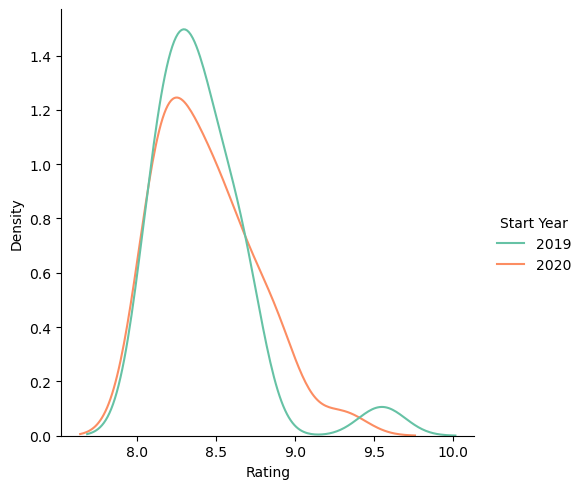

In [5]:
tv_shows_2019 = df[df['Start Year'] == 2019]
tv_shows_2020 = df[df['Start Year'] == 2020]

# Combine the two DataFrames into one
tv_shows_2019_2020 = pd.concat([tv_shows_2019, tv_shows_2020])

# Conduct a t-test to determine if there is a statistically significant difference in mean ratings between the two groups
t, p = stats.ttest_ind(tv_shows_2019['Rating'], tv_shows_2020['Rating'])

# Print the t-statistic and p-value
print(f"t-statistic: {t}, p-value: {p}")

# Visualize the distribution of ratings for each group using a distplot from seaborn
sns.displot(data=tv_shows_2019_2020, x='Rating', hue='Start Year', kind='kde', common_norm=False,palette="Set2")
plt.show()


## Top 10 shows by number of votes vs ratings

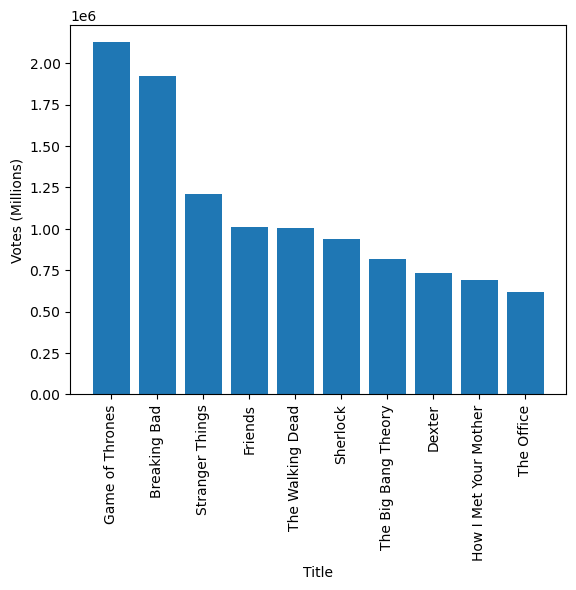

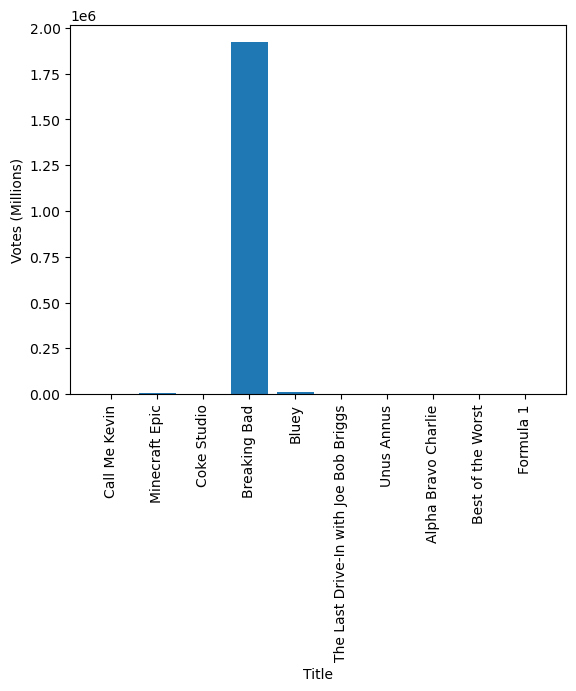

In [6]:
import matplotlib.pyplot as plt
import pandas as pd


# Sort the dataframe by the number of votes in descending order
byPopularity = df.sort_values(by='Votes', ascending=False)

# Get the top 10 rows of the sorted dataframe
byPopularity = byPopularity.head(10)

# Plot the data as a bar chart
plt.bar(byPopularity['Title'], byPopularity['Votes'])

# Add labels to the x and y axis
plt.xlabel('Title')
plt.xticks(rotation=90)
plt.ylabel('Votes (Millions)')

# Show the plot
plt.show()


byRating = df.head(10)

# Get the top 10 rows of the sorted dataframe
byRating = byRating.head(10)

# Plot the data as a bar chart
plt.bar(byRating['Title'], byRating['Votes'])


# Add labels to the x and y axis
plt.xlabel('Title')
plt.xticks(rotation=90)
plt.ylabel('Votes (Millions)')

# Show the plot
plt.show()



## Number of high-rated TV shows throughout time


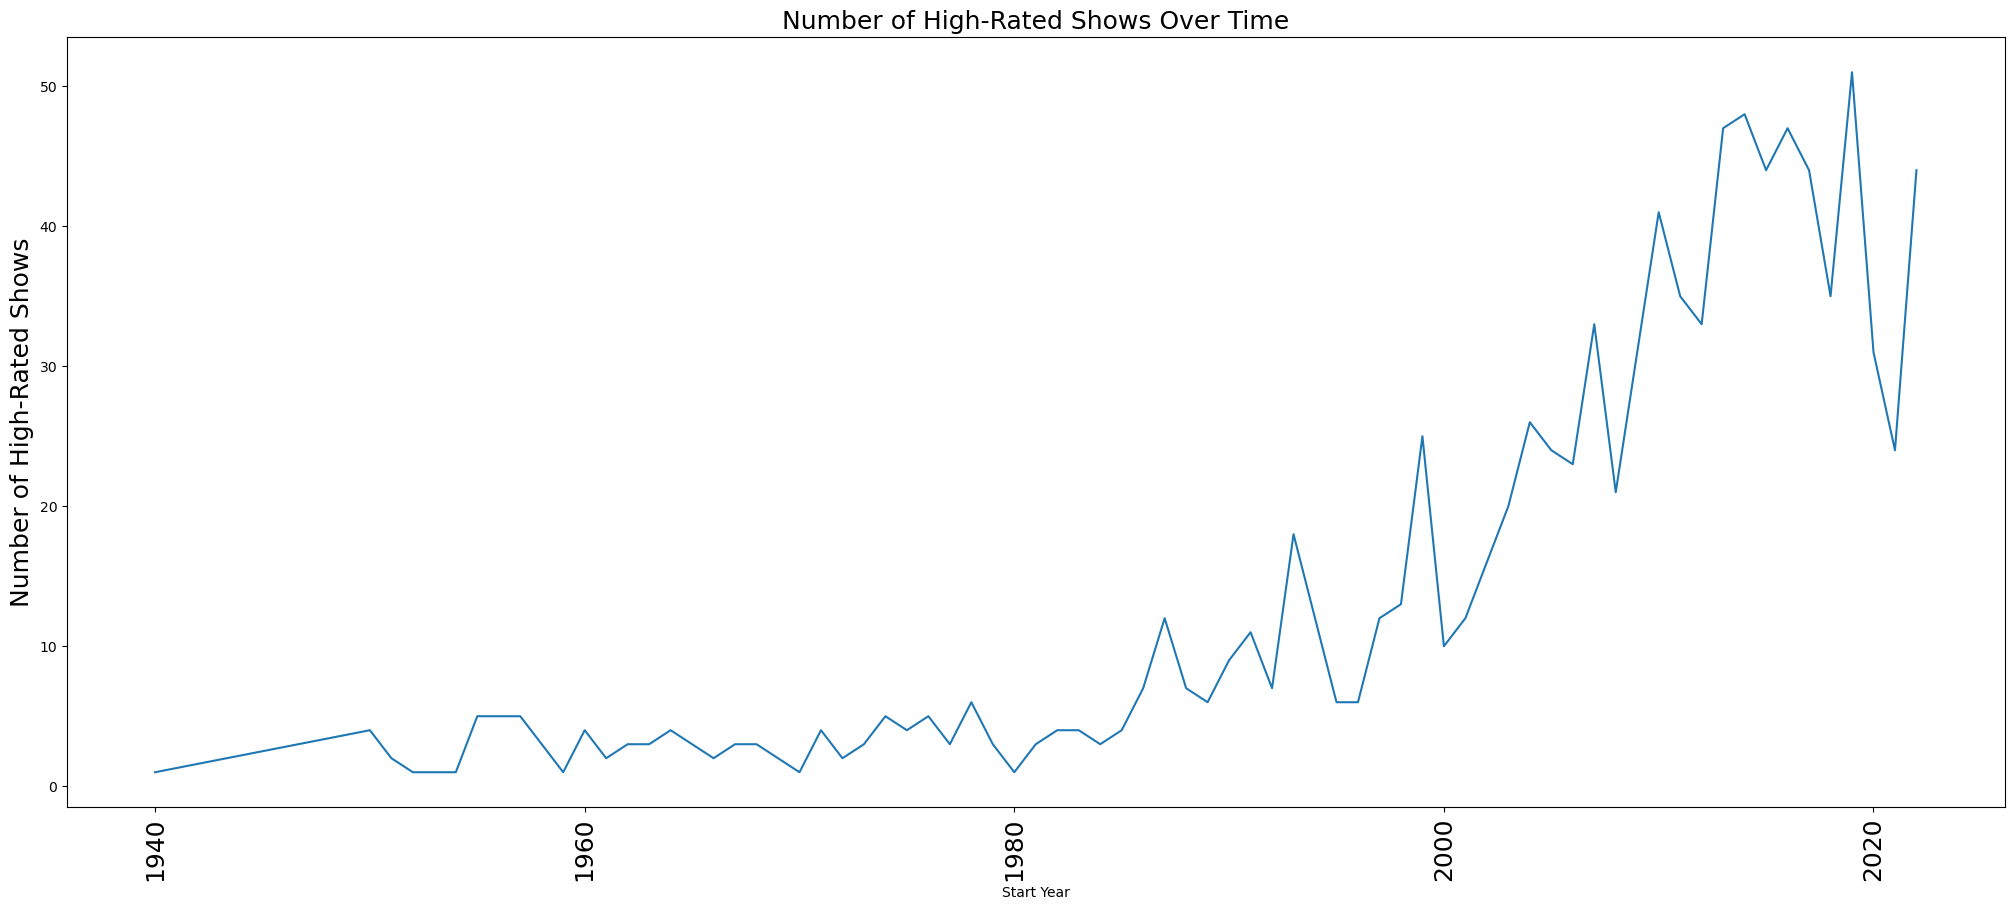

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(25, 10))
plt.xticks(rotation='vertical', fontsize=18)


# Define a threshold for the rating of a show to be considered "high-rated"
threshold = 8.0

# Calculate the number of high-rated shows for each year
high_rated_shows = []
years = sorted(set(df["Start Year"].tolist()))
years.pop()
for year in years:
    high_rated_count = sum([1 for index, row in df.iterrows() if (row["Start Year"] == year) & (row["Rating"] >= threshold)]) 
    high_rated_shows.append(high_rated_count)

# Plot the number of high-rated shows over time
plt.plot(years, high_rated_shows)
plt.xlabel("Start Year")
plt.ylabel("Number of High-Rated Shows",fontsize=18)
plt.title("Number of High-Rated Shows Over Time",fontsize=18)
plt.show()


## Adult Rating grouping

,Rank,Start Year,End Year,Rating,Votes
Maturity,,,,,
Adult,159016,661898,455219,2771.9,29780091
Non-Adult,271383,1046677,809733,4395.7,27621787


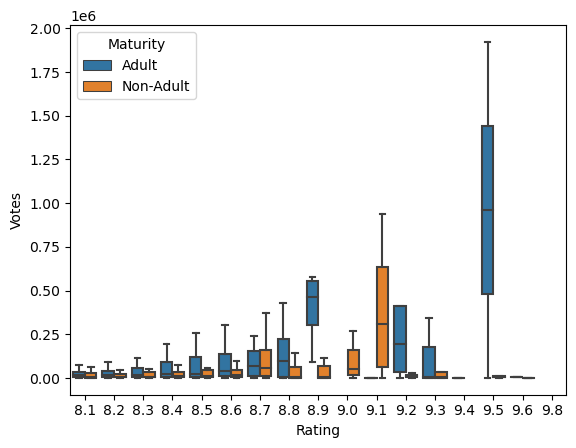

In [20]:
rating = {'Not Found' : None, 'TV-MA' : "Adult", 'Approved' : "Non-Adult", 'TV-Y' : "Non-Adult", 'Not Rated' : "Adult", 'TV-14' : "Non-Adult",
          'TV-PG' : "Non-Adult", 'TV-Y7-FV' : "Non-Adult", 'TV-G' : "Non-Adult", 'Unrated' : "Adult", 'TV-Y7' : "Non-Adult"}
df['Maturity'] = df['Certificate'].map(rating)

sns.boxplot(data = df, x = 'Rating', y = 'Votes', hue = 'Maturity', showfliers = False)
display(df.groupby('Maturity').sum())
plt.show()